In [ ]:
pip install seaborn

In [94]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [95]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [96]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [97]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [98]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<Axes: title={'center': 'Pearson Correlation of Features'}>

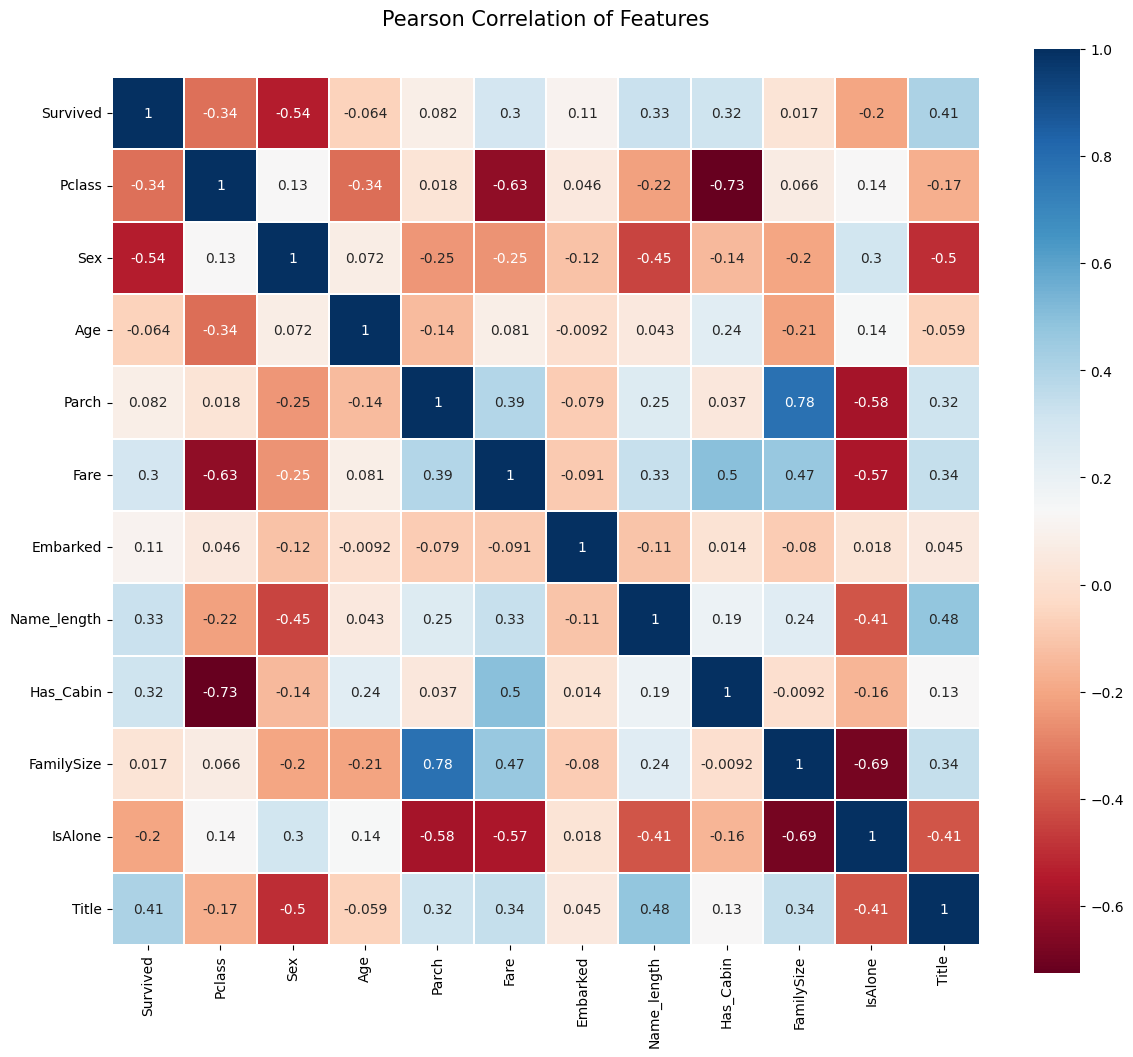

In [101]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

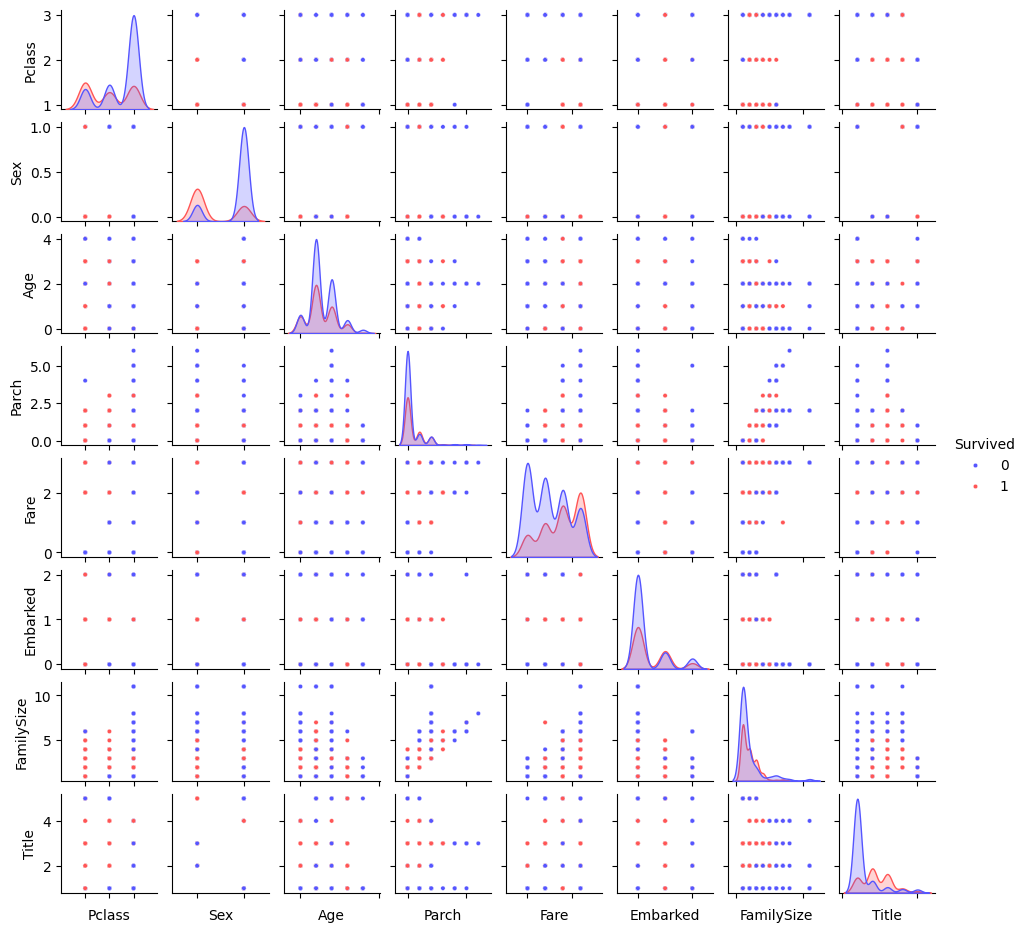

In [102]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

In [ ]:
train

In [ ]:
test

In [ ]:
# Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.
#Построение модели
# 1. Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, 
#SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

#Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 
#(в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

#Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [99]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17,shuffle=True)

In [100]:
import pandas as pd
import numpy as np

targets = train['Survived']
data = train.drop('Survived', axis=1)

In [ ]:
targets

In [ ]:
data

In [101]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    targets,
                                                    test_size=0.3,
                                                    random_state=17)
train, valid, train_true, valid_true = train_test_split(x_train, 
                                                        y_train,
                                                        test_size=0.3,
                                                        random_state=0)



In [ ]:
x_train, x_test, y_train, y_test

In [ ]:
# 2

 #   Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма 
#(в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

#    Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. 
#Выведите лучшее сочетание параметров для каждого из алгоритмов.

#    Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, 
# которая соответствует метрике оценки соревнования.

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_model = RandomForestClassifier(random_state=17)
grid_search_rf = GridSearchCV(rf_model, rfc_params,cv=skf)


rf_fit=grid_search_rf.fit(x_train, y_train)
#rf_fit
brf_fitest_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_
print('brf_fitest_params= ',brf_fitest_params,'best_score= ',best_score)

rf_models=[rf_fit]
meta_mtrx_rf = np.empty((valid.shape[0], len(rf_models)))
for n, rf_model in enumerate(rf_models):
 meta_mtrx_rf[:, n] = rf_model.predict(valid)
 rf_predicted = rf_model.predict(x_test)
 print(f'{n} auc: {roc_auc_score(y_test, rf_predicted)}')

brf_fitest_params=  {'min_samples_leaf': 2, 'n_estimators': 80} best_score=  0.8378322580645161
0 auc: 0.7786480748264188


In [103]:

from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(random_state=17)
grid_search_gbc= GridSearchCV(gbc_model, gbc_params,cv=skf)

gbc_fit=grid_search_gbc.fit(x_train, y_train)

gbc_fitest_params = grid_search_gbc.best_params_
gbc_best_score = grid_search_gbc.best_score_
print('gbc_fitest_params= ',gbc_fitest_params,'gbc_best_score= ',gbc_best_score)


gbc_models=[gbc_fit]

meta_mtrx_gbc = np.empty((valid.shape[0], len(gbc_models)))
for n, gbc_model in enumerate(gbc_models):
 meta_mtrx_gbc[:, n] = gbc_model.predict(valid)
 gbc_predicted = gbc_model.predict(x_test)
 print(f'{n} auc: {roc_auc_score(y_test, gbc_predicted)}')

gbc_fitest_params=  {'learning_rate': 0.1} gbc_best_score=  0.8329806451612903
0 auc: 0.7452516210477994


In [104]:
#from numpy.linalg import svd, det
#from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.metrics import roc_auc_score


svc_model = svm.SVC(random_state=17)
grid_search_svc= GridSearchCV(svc_model, svc_params,cv=skf)

svc_fit=grid_search_svc.fit(x_train, y_train)

svc_fitest_params = grid_search_svc.best_params_
svc_best_score = grid_search_svc.best_score_
print('svc_fitest_params= ',svc_fitest_params,'svc_best_score= ',svc_best_score)

svc_models=[svc_fit] 

meta_mtrx_svc = np.empty((valid.shape[0], len(svc_models)))
for n, svc_model in enumerate(svc_models):
 meta_mtrx_svc[:, n] = svc_model.predict(valid)
 svc_predicted = svc_model.predict(x_test)
 print(f'{n} auc: {roc_auc_score(y_test, svc_predicted)}')


svc_fitest_params=  {'C': 0.1, 'kernel': 'linear'} svc_best_score=  0.8089806451612904
0 auc: 0.7775578125896597


In [105]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=17)

grid_search_lr= GridSearchCV(lr_model, lr_params,cv=skf)

lr_fit=grid_search_lr.fit(x_train, y_train)

lr_fitest_params = grid_search_lr.best_params_
lr_best_score = grid_search_lr.best_score_
print('lr_fitest_params= ',lr_fitest_params,'lr_best_score= ',lr_best_score)

lr_models=[lr_fit] 

meta_mtrx_lr = np.empty((valid.shape[0], len(lr_models)))
for n, lr_model in enumerate(lr_models):
 meta_mtrx_lr[:, n] = lr_model.predict(valid)
 lr_predicted = lr_model.predict(x_test)
 print(f'{n} auc: {roc_auc_score(y_test, lr_predicted)}')

lr_fitest_params=  {'C': 0.5} lr_best_score=  0.8169548387096774
0 auc: 0.7902966660928444


In [ ]:
# 3.

#С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках 
#(используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, 
#полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [106]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [107]:
from xgboost import XGBClassifier
#from sklearn.metrics import roc_auc_score


meta_models = [rf_fit, lr_fit, gbc_fit, svc_fit]

meta_mtrx_m = np.empty((valid.shape[0], len(meta_models)))

#print(x_test,y_test,meta_predicted)

for n, model in enumerate(meta_models):
    meta_mtrx_m[:, n] = model.predict(valid)
    meta_predicted = model.predict(x_test)
    print(f'{n} auc: {roc_auc_score(y_test, meta_predicted)}')


meta = XGBClassifier(random_state=17)
meta_fit = meta.fit(meta_mtrx_m, valid_true)

grid_search_meta= GridSearchCV(meta, xgb_params,cv=5)

#print(grid_search_meta.best_params_) 


#meta_fitest_params = grid_search_meta.best_params_
#meta_best_score = grid_search_meta.best_score_
#print('meta_fitest_params= ',meta_fitest_params,'meta_best_score= ',meta_best_score)
#print(grid_search_meta)



# meta_fitest_params = grid_search_meta.best_params  # Исправлено на best_params
# meta_best_score = grid_search_meta.best_score_
# print('meta_fitest_params= ',meta_fitest_params,'meta_best_score= ',meta_best_score)



0 auc: 0.7786480748264188
1 auc: 0.7902966660928444
2 auc: 0.7452516210477994
3 auc: 0.7775578125896597
